In [40]:
import sidecar
import ipyleaflet
import datacube

In [42]:
dc = datacube.Datacube()

In [63]:
data = dc.load(product='ga_ls8c_ard_3', 
               lat=(-35, -36), lon=(148, 149),
               time='2018-01-01',
               group_by='solar_day',
               resolution=(30,30),
               output_crs='epsg:3577',
               dask_chunks={'time': 1, 'x': 2000, 'y': 2000})

In [68]:
from datacube.storage.masking import mask_invalid_data

In [69]:
blue = mask_invalid_data(blue)

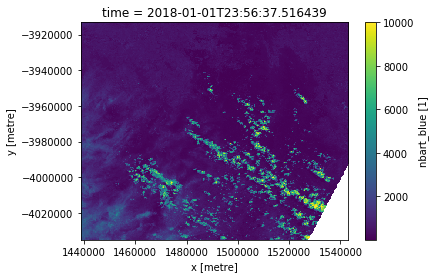

In [71]:
blue[0, ::10, ::10].plot.imshow();

In [100]:
from datacube.utils.geometry import GeoBox, Geometry, CRS

1/27" = 1 m
1/27 / 60 / 60 deg

In [118]:
DEGREES_PER_METER = 1 / (27 * 60 * 60)
DEGREES_PER_METER

1.02880658436214e-05

In [131]:
if 'metre' not in src_geobox.crs.units:
    dst_resolution = tuple(r / DEGREES_PER_METER for r in src_geobox.resolution)
else:
    dst_resolution = src_geobox.resolution

In [135]:
import numpy as np

In [137]:
from datacube.virtual.impl import reproject_array, reproject_band, compute_reproject_roi

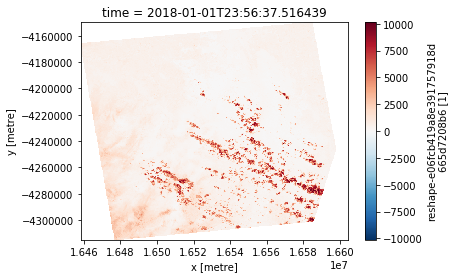

In [144]:
dst[0, ::10, ::10].plot();

In [145]:
from odc.algo import to_rgba

In [248]:
da = to_rgba(data, clamp=3000, bands=['nbart_red', 'nbart_green', 'nbart_blue'])

In [226]:
from collections.abc import Mapping

In [237]:
import xarray as xr

In [301]:
def reproject(ds, output_crs, output_res=None, resampling=None, dask_chunks=None):
    if isinstance(ds, xr.DataArray):
        return reproject_slice(ds, output_crs, output_res, resampling, dask_chunks)
    
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(ds.crs).units:
            raise ValueError
        else:
            output_res = ds.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(ds.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    output_bands = {}
    for band_name, band in ds.items():
        if hasattr(band.data, 'dask') and dask_chunks is None:
            dask_chunks = dict(zip(band.dims, band.data.chunksize))

        if isinstance(resampling, Mapping):
            band_resampling = resampling[band_name] if band_name in resampling else 'nearest'
        else:
            band_resampling = resampling
        output_bands[band_name] = reproject_band(band, output_geobox, resampling=band_resampling, dims=band.dims, dask_chunks=dask_chunks)
    
    return xr.Dataset(output_bands)

In [303]:
reproject(da, 'epsg:3857')

<xarray.DataArray 'reshape-aa0c808643a9ce7951e403e728e14621' (time: 1, y: 5509, x: 4876, band: 4)>
dask.array<transpose, shape=(1, 5509, 4876, 4), dtype=uint8, chunksize=(1, 2000, 2000, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2018-01-01T23:56:37.516439
  * y        (y) float64 -4.315e+06 -4.315e+06 ... -4.15e+06 -4.15e+06
  * x        (x) float64 1.646e+07 1.646e+07 1.646e+07 ... 1.66e+07 1.66e+07
  * band     (band) object 'r' 'g' 'b' 'a'
Attributes:
    crs:      epsg:3857
    nodata:   nan

In [298]:
def reproject_da(da, output_crs, output_res=None, resampling=None, dask_chunks=None):
    output_crs = CRS(output_crs)
    
    if output_res is None:
        if output_crs.units[0] not in CRS(da.crs).units:
            raise ValueError
        else:
            output_res = da.geobox.resolution

    output_geobox = GeoBox.from_geopolygon(da.geobox.geographic_extent, resolution=output_res, crs=output_crs)
    
    if hasattr(da.data, 'dask') and dask_chunks is None:
        dask_chunks = dict(zip(da.dims, da.data.chunksize))
        
    if 'nodata' not in da.attrs:
        da.attrs['nodata'] = np.nan

    return reproject_band(da, output_geobox, resampling=resampling, dims=da.dims, dask_chunks=dask_chunks)

In [294]:
def reproject_slice(da, output_crs, output_res, resampling, dask_chunks):
    bad_dims = [dim for dim, dim_size in da.sizes.items() if dim not in ('x', 'y') and dim_size > 1]
    if bad_dims:
        dim_name = bad_dims[0]
        return xr.concat([reproject_slice(
            da.isel(**{dim_name:i}), output_crs, output_res, resampling, dask_chunks
                   ) for i in range(da[dim_name].size)], dim=dim_name).transpose(*da.dims)
    else:
        return reproject_da(da, output_crs, output_res, resampling, dask_chunks)

In [295]:
reproject(da)[:,::10, ::10].plot();

TypeError: reproject() missing 1 required positional argument: 'output_crs'

In [296]:
reprojected_data = reproject(da, 'epsg:3857')

AssertionError: 

In [285]:
reprojected_data.plot();

AttributeError: '_Dataset_PlotMethods' object has no attribute 'imshow'